TFRecord : Tensorflow에서만 사용이 가능한 자료구조  
1) binary 포맷이기 때문에 빠르게 입출력 처리가 가능  
2) 데이터를 직렬화(Serialization)해서 저장하는 방식  
3) 기본적으로 google protocal buffer를 활용  

***
1. (학습)데이터와 label이 따로 관리되지 않고 같이 관리됨 ==> 편하다! 두둥!! !_!  
2. Encoding, Decoding 작업이 필요없는 이진데이터 형식임 ==> 속도를 올릴 수 있음! ㅇ0ㅇ  
3. 용량이 줄어듬  

In [2]:
import tensorflow as tf
filenames = tf.io.gfile.glob('../data/kaggle_cat_dog/train/*.jpg')
print(len(filenames))

25000


../data/kaggle_cat_dog/train/cat.12406.jpg ../data/kaggle_cat_dog/train/cat.3199.jpg
image의 shape : (288, 299, 3)


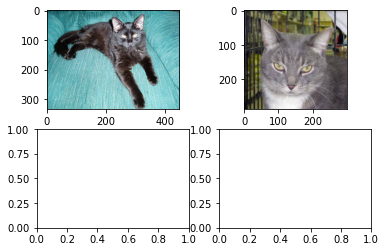

In [4]:
import warnings
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import io

warnings.filterwarnings(action='ignore')

filenames = tf.io.gfile.glob('../data/kaggle_cat_dog/train/*.jpg')

print(filenames[0], filenames[1])

# filenames[0], filenames[1] 파일의 shape과 이미지를 먼저 살펴보자.
fig = plt.figure()

axes = []

for i in range(4):
    axes.append(fig.add_subplot(2,2,i+1))
    
img = Image.open(filenames[0])
pixel = np.array(img)
axes[0].imshow(pixel)

img = Image.open(filenames[1])
pixel = np.array(img)
axes[1].imshow(pixel)


print('image의 shape : {}'.format(pixel.shape))



In [5]:
############ Tensorflow에서 제공된 Type별 Feature 생성 코드 ############

def _bytes_feature(value):
    # string / byte 타입을 받아서 byte list를 리턴.
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _floatarray_feature(array):
    # float / double 타입을 받아서 float list를 리턴
    return tf.train.Feature(float_list=tf.train.FloatList(value=array))

def _int64_feature(value):
    # bool / enum / int / uint 타입을 받아서 int64 list를 리턴
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


# tf.Example 객체 생성                  ## tf가 제공해주는 Example이라는 이름의 class임
def to_example(filename):
    image_string = tf.io.read_file(filename)    
    
    # './data/kaggle_cat_dog/train/cat.12406.jpg'
    label = (filename.split('/')[-1]).split('.')[0] == 'dog'
    # cat이면 False(0), dog이면 True(1)
       
    shape = tf.image.decode_jpeg(image_string).shape

    feature = {
        'image/height': _int64_feature(shape[0]),
        'image/width': _int64_feature(shape[1]),
        'image/channel': _int64_feature(shape[2]),
        'image/label': _int64_feature(label),
        'image/image_raw': _bytes_feature(image_string),
        'image/filename': _bytes_feature(filename.encode())
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

# TFRecord 파일 생성
tfrecords_path = './TFRecord_Write_Read_Example.tfrecords'

with tf.io.TFRecordWriter(tfrecords_path) as writer:
    try:
        # print(to_example(filenames[0]).SerializeToString())
        tf_example = to_example(filenames[0])
        writer.write(tf_example.SerializeToString())
        tf_example = to_example(filenames[1])
        writer.write(tf_example.SerializeToString())        
    except:
        print(f'fail: {filename}')

2022-04-22 13:33:51.930498: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-22 13:33:51.931877: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-22 13:33:51.932150: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
import os
print(os.getcwd())

/home/lab17/jupyter_home/code


image의 shape : (288, 299, 3)


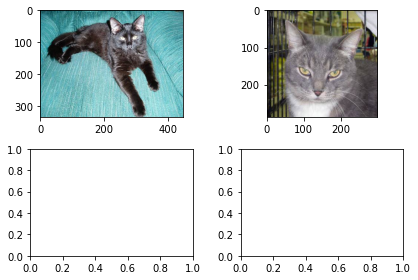

In [8]:
# TFRecord 파일로 부터 data 복구

raw_image_dataset = tf.data.TFRecordDataset(tfrecords_path)

# Create a dictionary describing the features.
image_feature_description = {
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/channel': tf.io.FixedLenFeature([], tf.int64),
    'image/label': tf.io.FixedLenFeature([], tf.int64),
    'image/image_raw': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string)
}


def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)

k=2

for image_features in parsed_image_dataset:
    
    image_raw = image_features['image/image_raw'].numpy()  # byte array
    image_label = image_features['image/label'].numpy()  # byte array
      
    decoded = np.array(Image.open(io.BytesIO(image_raw)))  # ndarray   

    axes[k].imshow(decoded)
    axes[k].set_title('image label : {}'.format(image_label))
    k+=1
    
    

# filenames[0], filenames[1] 파일의 shape과 이미지를 먼저 살펴보자.
fig = plt.figure()

axes = []

for i in range(4):
    axes.append(fig.add_subplot(2,2,i+1))
    
img = Image.open(filenames[0])
pixel = np.array(img)
axes[0].imshow(pixel)

img = Image.open(filenames[1])
pixel = np.array(img)
axes[1].imshow(pixel)


print('image의 shape : {}'.format(pixel.shape))



plt.tight_layout()
plt.show()